In [53]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions for minhash

In [59]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = str(aString).split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures

def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

def lsh(signatures_dict, jaccard_threshold=0.6, seed=42):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        print(i)
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
                    #print((list_keys[i], list_keys[j]))
                    #print(similar_items[(list_keys[i], list_keys[j])])
    return similar_items

## Import data

In [60]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data.csv")

In [61]:
df.head()

,overall,reviewText,Clean_Review
0,1.0,I have been involved with computers for 22 yea...,involve computer year expert design program co...
1,1.0,Downloaded KIS7 because previous subscription ...,download previous subscription expire load say...
2,1.0,Norton Security has been working fine for the ...,norton security work fine last year start use ...
3,1.0,same ol' same ol' from Microsoft - but what ca...,ol ol microsoft expect company large dysfuncti...
4,1.0,I have been using Quicken since the 2nd DOS ve...,use quicken since do version cannot understand...


## Create minhash signatures for each review

In [62]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 1, num_hashes = k)

# sim_items = lsh(sigs)


## Clustering based on minhash signatures

In [63]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [64]:
X = dic_to_vec(sigs)

In [65]:
y = np.array(df.overall.values)

## KMeans clustering

In [100]:
from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

'0.24.2'

In [68]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [69]:
X_transform = k_means.fit_transform(X,y)

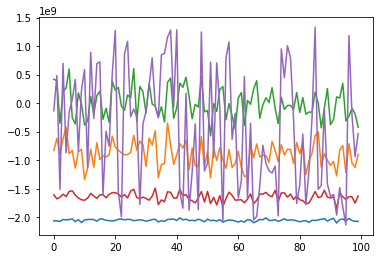

In [70]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [72]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [73]:
assigned = assign_cluster(centroids, sigs)

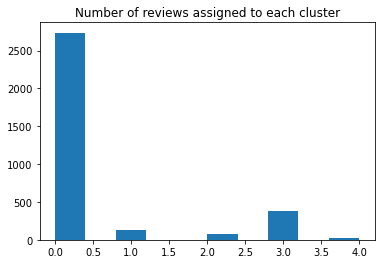

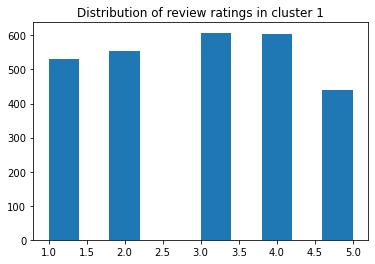

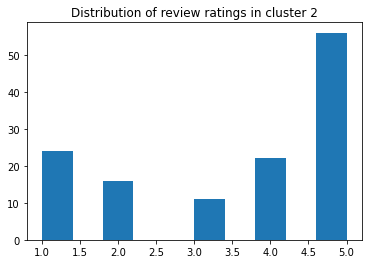

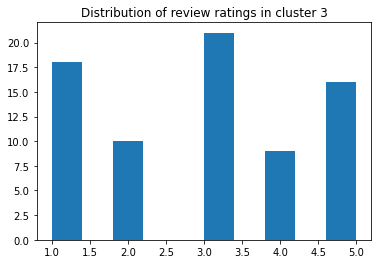

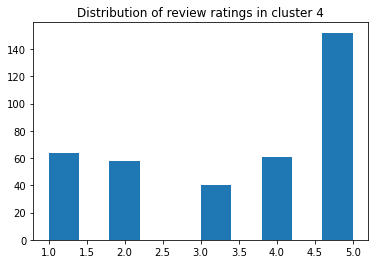

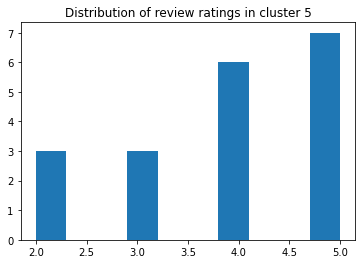

In [76]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    #print(df_slice)
    #review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

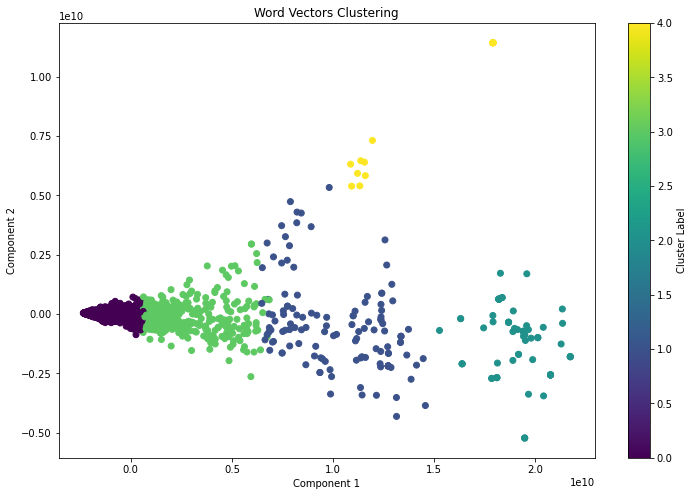

In [81]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [182]:
from collections import Counter

def get_tf_idf(df_docs,assignments = None):
    documents = np.array(df_docs.Clean_Review.values)
    
    N = len(documents)
    
    all_words = {}
    
    # Get number of document appearances for all words:
    for i in range(N):
        text = str(documents[i]).split(" ")
        unique_words = np.unique(text)
        
        for word in unique_words:
            if word not in all_words.keys():
                all_words[word] = 1
            else:
                all_words[word] = all_words[word] + 1
    
    
    
    if not(assignments is None):
        """ Collect all text from reviews in a cluster into one single 'document' """
        assignments = np.asarray(list(assignments.values()))
        clusters = np.unique(assignments)
        documents = []
        for i in clusters:
            cluster_reviews = df.loc[assignments == i,"Clean_Review"].values
            all_text = cluster_reviews[0]
            for j in range(1, len(cluster_reviews)):
                all_text += " " + str(cluster_reviews[j])
            documents.append(all_text)
        documents = np.asarray(documents,str)
        
        N = len(documents)
        
        all_words_clusters = {}

        # Get number of document appearances for all words:
        for i in range(N):
            text = str(documents[i]).split(" ")
            unique_words = np.unique(text)

            for word in unique_words:
                if all_words[word] <= 5:
                    continue
                elif word not in all_words_clusters.keys():
                    all_words_clusters[word] = 1
                else:
                    all_words_clusters[word] = all_words_clusters[word] + 1
        all_words = all_words_clusters
        
        tf_idf = {}
        tf_idf_sparse_matrix = []
        for i in range(N):
            text = str(documents[i]).split(" ")
            word_freq = Counter(text)
            max_freq = max(word_freq.values())
            tf_doc = {}

            tf_idf_vector = np.zeros(len(all_words))
            for word in all_words.keys():
                if word in word_freq.keys():
                    tf_doc[word] = word_freq[word]/max_freq*np.log2(N/all_words[word])
                    index = list(all_words).index(word)
                    tf_idf_vector[index] = tf_doc[word]
            tf_idf[i] = tf_doc
            tf_idf_sparse_matrix.append(tf_idf_vector)
        tf_idf_sparse_matrix = np.asarray(tf_idf_sparse_matrix)
    else:
        tf_idf = {}
        tf_idf_sparse_matrix = []
        for i in range(N):
            text = str(documents[i]).split(" ")
            word_freq = calculate_word_frequency(text)
            max_freq = max(word_freq.values())
            tf_doc = {}

            tf_idf_vector = np.zeros(len(all_words))        
            for word in word_freq.items():
                tf_doc[word[0]] = word[1]/max_freq*np.log2(N/all_words[word[0]])

                index = list(all_words).index(word[0])

                tf_idf_vector[index] = tf_doc[word[0]]

            tf_idf[i] = tf_doc
            tf_idf_sparse_matrix.append(tf_idf_vector)
        tf_idf_sparse_matrix = np.asarray(tf_idf_sparse_matrix)
    
    return tf_idf, tf_idf_sparse_matrix, all_words

def find_n_largest_tfidf(tf_idf,n=5):
    largest_tfidf = {}
    for key in tf_idf:
        word_dict = tf_idf[key]
        words = np.asarray(list(word_dict.keys()))
        values = np.asarray(list(word_dict.values()))
        sort_values = np.argsort(values)[-n:][::-1]
        high_tf_idf = {}
        for i in sort_values:
            high_tf_idf[words[i]] = word_dict[words[i]]
        largest_tfidf[key] = high_tf_idf
    return largest_tfidf


In [189]:
tf_idf, tf_idf_sp_mat, all_words_count = get_tf_idf(df)

In [192]:
tf_idf_sp_mat

array([[ 0.22507841,  0.14042772,  0.52995802, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.32489505, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.57447705,  0.        , ...,  1.06387324,
         1.06387324,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 11.7026056 ]])

In [172]:
tf_idf_clusters, tf_idf_sp_mat, all_words = get_tf_idf(df, assigned)

In [174]:
find_n_largest_tfidf(tf_idf_clusters, n=5)

{0: {'one': 0.5813038853739215,
  'computer': 0.5192981376007032,
  'software': 0.49371093550548234,
  'program': 0.4681051819622482,
  'go': 0.45757945347458323},
 1: {'product': 0.42431352391387633,
  'work': 0.32192809488736235,
  'great': 0.2926619044430567,
  'much': 0.17865832585847424,
  'price': 0.17865832585847424},
 2: {'nan': 0.6965784284662087,
  'okay': 0.3965784284662087,
  'work': 0.32192809488736235,
  'ok': 0.28973528539862614,
  'satisfied': 0.2643856189774725},
 3: {'product': 0.4454792024437515,
  'computer': 0.404470536495387,
  'year': 0.3574833106030105,
  'use': 0.32192809488736235,
  'software': 0.26398767552222313},
 4: {'good': 0.32192809488736235,
  'sw': 0.06957516288880855,
  'far': 0.03878766285085296,
  'enough': 0.03878766285085296,
  'thought': 0.016943583941440122}}

0

## Supervised learning with tf_idf


In [101]:
df_neg = df.loc[df['overall']<2.5]
df_neu = df.loc[df['overall']==3]
df_pos = df.loc[df['overall']>3.5]

In [179]:
assignments = {}
for i in range(len(df.index)):
    rating = df.iloc[i]['overall']
    assignments[i] = (-1 if rating < 2.5 else (1 if rating > 3.5 else 0))

In [183]:
tf_idf_clusters = get_tf_idf(df, assignments)

In [202]:
find_n_largest_tfidf(tf_idf_clusters[0], n=100)

{0: {'august': 0.01859799544522869,
  'tile': 0.012583939063753685,
  'crappy': 0.01239866363015246,
  'unusable': 0.010677281629851612,
  'deletion': 0.008770624195949539,
  'moneydance': 0.008770624195949539,
  'crap': 0.008389292709169124,
  'insult': 0.008265775753434972,
  'july': 0.007626629735608295,
  'shame': 0.007626629735608295,
  'ibank': 0.006482635275267051,
  'eel': 0.00619933181507623,
  'china': 0.00619933181507623,
  'worthless': 0.006101303788486635,
  'revert': 0.006101303788486635,
  'cripple': 0.005719972301706221,
  'brokerage': 0.005338640814925806,
  'india': 0.004957309328145391,
  'worst': 0.004957309328145391,
  'greed': 0.004575977841364977,
  'trash': 0.004575977841364977,
  'disappointing': 0.004194646354584562,
  'broadband': 0.004194646354584562,
  'everywhere': 0.004194646354584562,
  'quicker': 0.004194646354584562,
  'massive': 0.004194646354584562,
  'reboots': 0.0038133148678041475,
  'avira': 0.0038133148678041475,
  'lousy': 0.0038133148678041475

In [42]:
ass = np.asarray(list(assignments.values()))
n_clusters = len(np.unique(ass))


In [201]:
print(tf_idf_clusters[0][0]['good'])
print(tf_idf_clusters[0][1]['crap'])
print(tf_idf_clusters[0][2]['crap'])

0.0


KeyError: 'crap'

n_clusters


In [ ]:
file = "cluster_100_2_2.dat"
filepath = Path.cwd() / 'Data' / file
n, d, points = load_dat(filepath)


## The (naíve) k-means algorithm for 2D data and 2 cluster

# Step 0: Initialisation
# lets do the most basic initialisation 
# where points are picked at random

idx = np.random.randint(len(points), size=2)
representative_1, representative_2 = points[idx, :]

cluster_1 = [representative_1]
cluster_2 = [representative_2]
labels = []

def centroid(cluster_i):
    return np.sum(cluster_i, axis=0) / len(cluster_i)

# (Re)assign each data point p to the cluster C_i
# for which the distance between p and the centroid
# of C_i
for p in points:
    
    # lets use euclidean distance
    d_1 = np.sqrt(np.sum(np.square(centroid(cluster_1) - p)))
    d_2 = np.sqrt(np.sum(np.square(centroid(cluster_2) - p)))
    
    if d_1 < d_2:
        cluster_1.append(p)
        labels.append(1)
    else:
        cluster_2.append(p)
        labels.append(2)
        
plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.show()